# Interpret simple cubic model

In the supplementary information for the article, we describe a simple model that excludes age and represents both ```firstpub``` and ```birthyear``` as cubic polynomials.

Here we calculate average delta for that model.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr

In [2]:
interpret = pd.read_csv('../interrater/k200standardcoding.tsv', sep = '\t')
interpret.drop(columns = ['next5books, biggestauth, datequartiles', 'comments'], inplace = True)
interpret.head()

,topicstats,keywords,top7books,label,category
0,TOPIC 0 pct corpus = 0.267% doc entropy = 9.80...,war german french germans france germany ameri...,"0.136 | Gibbs, Philip | Through the storm | 19...","war, mostly WWII",event
1,TOPIC 1 pct corpus = 0.288% doc entropy = 9.74...,professor man quite something thing old little...,"0.177 | Stewart, J. I. M. (John Innes | Hare ...","e20c scientists, labs, and professors, mostly ...",genre
2,TOPIC 2 pct corpus = 0.479% doc entropy = 10.4...,door put box paper hand took room went made po...,"0.489 | Sellers, Tom | Unknown Title | 1927 0....","objects in relation to doors, pockets, rooms, ...",physical description
3,TOPIC 3 pct corpus = 0.388% doc entropy = 9.34...,american people president our security re new ...,"0.297 | Digo, Benjamin | Creator of Nikho | 19...",late 20c US political thrillers,genre
4,TOPIC 4 pct corpus = 0.666% doc entropy = 10.3...,man old people men because knew good always bi...,"0.157 | Hanley, Gerald | Drinkers of darkness ...",diffuse,uncategorized dimension of style


In [10]:
cube = pd.read_csv('topicmodel_cubic.csv')
cube.head()

,depvar,cmse,pmse,totalr2,delta
0,t0,6.127,5.262,0.012465,0.537975
1,t1,0.234,36.631,0.014080,0.006347
2,t2,14.017,0.888,0.004137,0.940423
3,t3,51.492,3.412,0.123907,0.937855
4,t4,82.192,11.749,0.023321,0.874932


In [5]:
# FUNCTIONS THAT SIMPLIFY AND CLEAN THE CODING FRAME

def getpct(astring):
    firstpart = astring.split('%')[0]
    number = float(firstpart.split('= ')[1])
    return number

def shorten(astring):
    shortversion = astring[0:6]
    if shortversion == 'human ':
        shortversion = 'institu' # for human institution, practice, or relationship
    return shortversion

interpret['pct'] = interpret.topicstats.map(getpct)
interpret['category'] = interpret.category.map(shorten)
interpret.drop(columns = ['keywords', 'top7books', 'topicstats'], inplace = True)
interpret.head()

,label,category,pct
0,"war, mostly WWII",event,0.267
1,"e20c scientists, labs, and professors, mostly ...",genre,0.288
2,"objects in relation to doors, pockets, rooms, ...",physic,0.479
3,late 20c US political thrillers,genre,0.388
4,diffuse,uncate,0.666


In [13]:
result = pd.concat([cube, interpret], axis = 1)

def weighted_avg(aframe):
    avg = sum(aframe.pct * aframe.cmse) / (sum(aframe.pct * aframe.cmse) + sum(aframe.pct * aframe.pmse))
    return avg

In [14]:
print("Overall, weighted in-sample is", round(weighted_avg(result), 4))

Overall, weighted in-sample is 0.5033


In [15]:
root = 'topicmodel_deltas'

deltas = dict()

for i in range(1, 6):
    
    suffix = str(i) + '.csv'
    deltas[i] = pd.read_csv(root + suffix)
    
print(len(deltas), ' files loaded.')

smoothed = dict()

cols = ['delta', 'adjdelta', 'delta_oos', 'cmse', 'pmse', 'cmse_oos', 'pmse_oos', 
        'totalr2', 'r2_oos', 'bydf', 'fpdf', 'agemse']

for c in cols:
    if c not in smoothed:
        smoothed[c] = []
    for rownum in range(200):
        values = []
        for i in range(1, 6):
            if c in deltas[i].columns:      # the only exception is 'agemse' which got added late
                                            # and won't be in all five runs
                values.append(deltas[i].loc[rownum, c])
        smoothed[c].append(np.mean(values))

        
avgdf = pd.DataFrame(smoothed)

5  files loaded.


In [19]:
spearmanr(avgdf.delta, result.delta)

SpearmanrResult(correlation=0.24072901822545567, pvalue=0.0005953611366448949)

In [20]:
spearmanr(avgdf.delta, avgdf.delta_oos)

SpearmanrResult(correlation=0.7620925523138079, pvalue=3.095539430417147e-39)

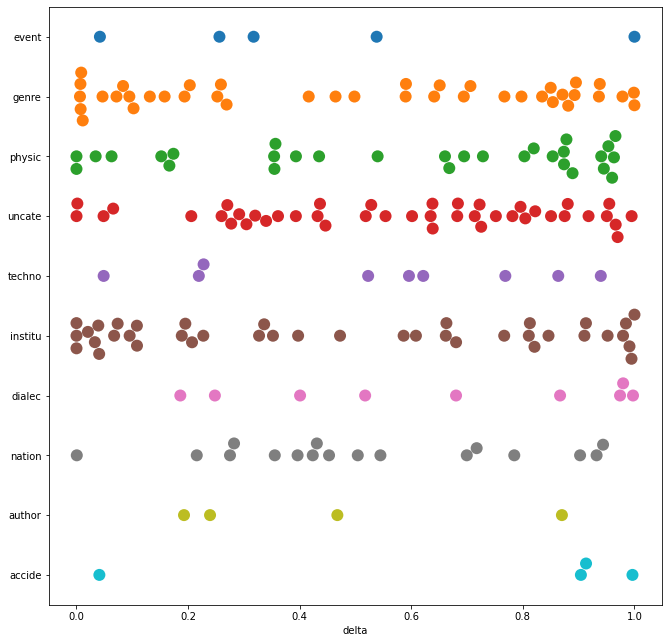

In [18]:
cm = 1/2.54
plt.figure(figsize = (11, 11))
res = sns.swarmplot(data = result, x = 'delta', y = 'category', orient = 'h', size = 12)
plt.rcParams.update({'font.size': 20})
plt.ylabel('')
#plt.gcf().set_facecolor('white')
#plt.savefig('/Users/tunder/Dropbox/python/cohort/figures', bbox_inches = 'tight', dpi = 300)
plt.show()